# Tutorial on Bayesian linear regression

**Alfredo Garbuno-Inigo**  
Phd student, University of Liverpool  
Institute for Risk and Uncertainty

In [1]:
%matplotlib inline
from pymc3 import *
import pymc3 as pm
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

SMALL_SIZE = 14
MEDIUM_SIZE = 18
BIGGER_SIZE = 20

plt.rc('font', size=SMALL_SIZE)          # controls default text sizes
plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize
plt.rc('figure', titlesize=BIGGER_SIZE)  # fontsize of the figure title

# Case study: Admittance to university. 


In [2]:
d = {'dept': ['A','A','B','B','C','C','D','D','E','E','F','F'], 
    'gender': ['male','female','male','female','male','female','male','female','male','female','male','female'], 
    'admit': [512,89,353,17,120,202,138,131,53,94,22,24], 
    'reject': [313,19, 207, 8,205,391 ,279, 244, 138 ,299, 351, 317], 
     'applications': [825,108,560,25,325,593,417,375,191,393,373,341]
    }
df = pd.DataFrame(d)

In [3]:
df.head(3)

,admit,applications,dept,gender,reject
0,512,825,A,male,313
1,89,108,A,female,19
2,353,560,B,male,207


In [4]:
dfsum = df.sum()[['admit','reject','applications']]
dfsum

admit           1755
reject          2771
applications    4526
dtype: object

# Case study: Admittance to university. 

In [5]:
print 'Acceptance rate: %s' %(np.ceil(100*(dfsum['admit']+0.0)/dfsum['applications']))

Acceptance rate: 39.0


In [6]:
df.groupby('gender').sum().apply(lambda x: (100*x['admit']+0.)/x['applications'], axis=1)

gender
female    30.354223
male      44.518766
dtype: float64

In [7]:
df.groupby('dept').sum()[['admit','reject', 'applications']]

,admit,reject,applications
dept,,,
A,601,332,933
B,370,215,585
C,322,596,918
D,269,523,792
E,147,437,584
F,46,668,714


In [8]:
df.groupby('dept').sum().apply(lambda x: 100.0*x[['admit','reject']]/x['applications'],axis=1)

,admit,reject
dept,,
A,64.415863,35.584137
B,63.247863,36.752137
C,35.076253,64.923747
D,33.964646,66.035354
E,25.171233,74.828767
F,6.442577,93.557423


In [9]:
depts = df.dept.unique()
n_depts = len(depts)
dept_table = dict(zip(depts, range(n_depts)))
dept = df.dept.replace(dept_table).values

dept_table

{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5}

In [10]:
gender = df.gender.replace(dict(zip(df.gender.unique(), range(2))))

dict(zip(df.gender.unique(), range(2)))

{'female': 1, 'male': 0}

## Pooled model

In [11]:
with Model() as pooled_model:
    # Priors in regression coefficients
    beta = Normal('beta', 0, sd=1e1, shape=2)
    # Linear model
    theta = beta[0] + beta[1]*gender

    # This just computes the link function, no posterior sampling
    # p = pm.invlogit(theta)
    
    # To get posterior samples set as a deterministic transformation
    p = pm.Deterministic('p', pm.invlogit(theta))
    
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [12]:
n_samples = 3000
n_opt = 20000
n_warm = 1000

with pooled_model:
    pooled_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 453.56:  48%|████▊     | 9521/20000 [00:01<00:01, 7470.18it/s]
Convergence archived at 10000
Interrupted at 10,000 [50%]: Average Loss = 557.58
100%|██████████| 4000/4000 [00:07<00:00, 505.65it/s]


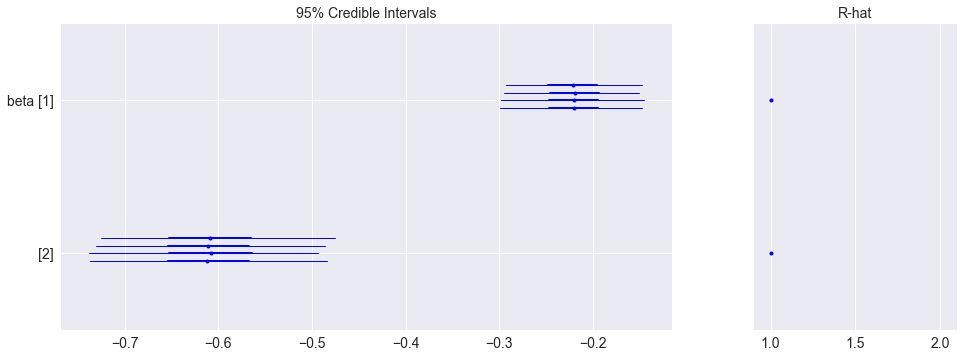

In [13]:
plt.figure(figsize=(15, 5))
forestplot(pooled_trace[1000:], varnames = ['beta'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x1183a4cd0>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1182f1c50>]], dtype=object)

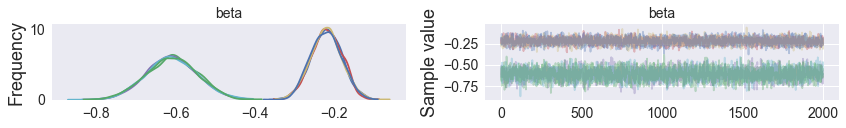

In [14]:
plt.figure(figsize=(15, 5))
pm.traceplot(pooled_trace[1000:], varnames = ['beta'])

array([<matplotlib.axes._subplots.AxesSubplot object at 0x119250510>,
       <matplotlib.axes._subplots.AxesSubplot object at 0x119358490>], dtype=object)

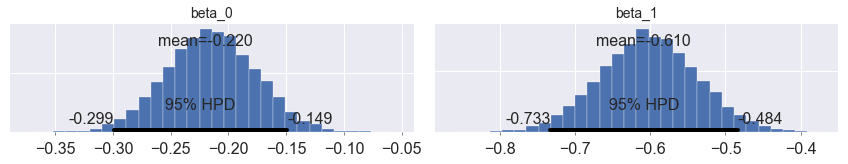

In [15]:
plt.figure(figsize=(15, 5))
pm.plot_posterior(pooled_trace[1000:], varnames = ['beta'])

In [16]:
dfsort = df.sort_values(['dept','gender'],ascending=[True, False])
pobs = 1.*dfsort['admit']/dfsort['applications']

phat = pd.Series(pooled_trace[n_warm:]['p'].mean(axis = 0))
pstd = np.sqrt(phat*(1 - phat)/dfsort.applications)

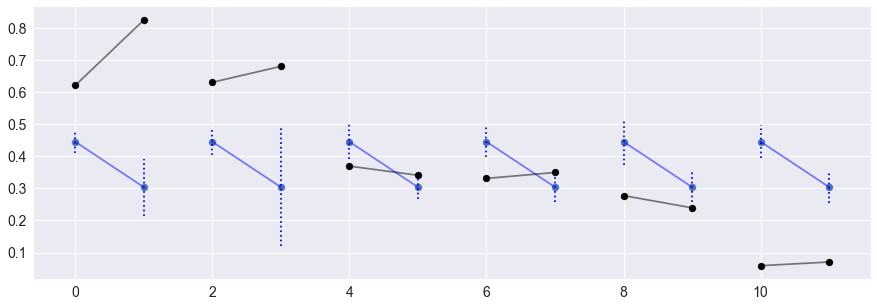

In [17]:
plt.figure(figsize=(15, 5))
plt.scatter(range(len(phat)), phat)
plt.scatter(range(len(phat)), pobs, c='k')
for i, m, se in zip(range(len(phat)), phat, pstd):
    plt.plot([i,i], [m-2*se, m+2*se], 'b:')
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [phat[i], phat[i+1]], 'b', alpha = .5)
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [pobs[i], pobs[i+1]], 'k', alpha = .5)

## Unpooled model

In [18]:
with Model() as unpooled_model:
    # Priors in regression coefficients
    beta = Normal('beta', 0, sd=1e1)
    alpha = Normal('alpha', 0, sd = 1e1, shape=n_depts)
    # Linear model
    theta = alpha[dept] + beta * gender

    # This just computes the link function, no posterior sampling
    # p = pm.invlogit(theta)
    
    # To get posterior samples set as a deterministic transformation
    p = pm.Deterministic('p', pm.invlogit(theta))
    
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [19]:
with unpooled_model:
    unpooled_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 81.429:  61%|██████    | 12152/20000 [00:01<00:01, 5900.63it/s]
Convergence archived at 12700
Interrupted at 12,700 [63%]: Average Loss = 239.95
100%|██████████| 4000/4000 [00:11<00:00, 355.82it/s]


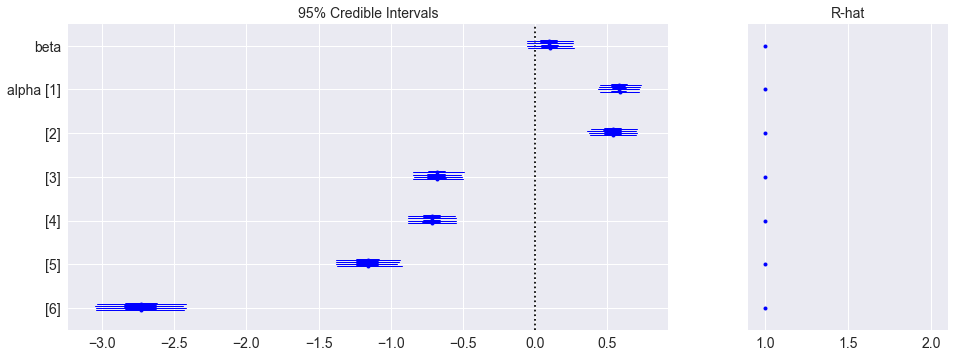

In [20]:
plt.figure(figsize=(15, 5))
forestplot(unpooled_trace[1000:], varnames = ['beta', 'alpha'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11a209210>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11a35b550>]], dtype=object)

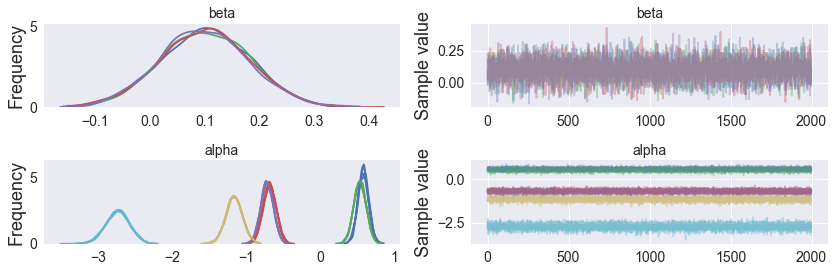

In [21]:
plt.figure(figsize=(15, 5))
pm.traceplot(unpooled_trace[1000:], varnames = ['beta', 'alpha'])

In [22]:
phat_unpooled = pd.Series(unpooled_trace[n_warm:]['p'].mean(axis = 0))
pstd_unpooled = np.sqrt(phat_unpooled*(1 - phat_unpooled)/dfsort.applications)

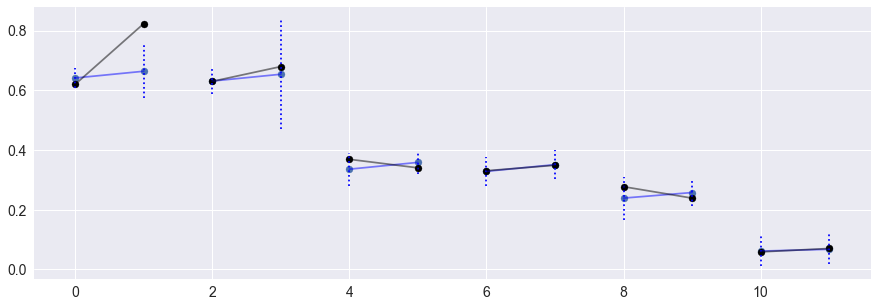

In [23]:
plt.figure(figsize=(15, 5))
plt.scatter(range(len(phat)), phat_unpooled)
plt.scatter(range(len(phat)), pobs, c='k')
for i, m, se in zip(range(len(phat)), phat_unpooled, pstd):
    plt.plot([i,i], [m-2*se, m+2*se], 'b:')
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [phat_unpooled[i], phat_unpooled[i+1]], 'b', alpha = .5)
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [pobs[i], pobs[i+1]], 'k', alpha = .5)

## Full hierarchical: *varying intercept*

In [24]:
with Model() as hierarchical:
    # Priors in 
    mu_a = Normal('mu_a', mu=0., sd=1e1)
    sigma_a = HalfCauchy('sigma_a', 5)
    
    # Priors in regression coefficients
    beta = Normal('beta', 0, sd=1e1)
    alpha = Normal('alpha', mu_a, sd = sigma_a, shape=n_depts)
    # Linear model
    theta = alpha[dept] + beta * gender

    # This just computes the link function, no posterior sampling
    # p = pm.invlogit(theta)
    
    # To get posterior samples set as a deterministic transformation
    p = pm.Deterministic('p', pm.invlogit(theta))
    
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [25]:
with hierarchical:
    hierarchical_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 74.596:  69%|██████▉   | 13825/20000 [00:02<00:01, 5323.08it/s]
Convergence archived at 14000
Interrupted at 14,000 [70%]: Average Loss = 220.55
100%|██████████| 4000/4000 [00:13<00:00, 294.43it/s]


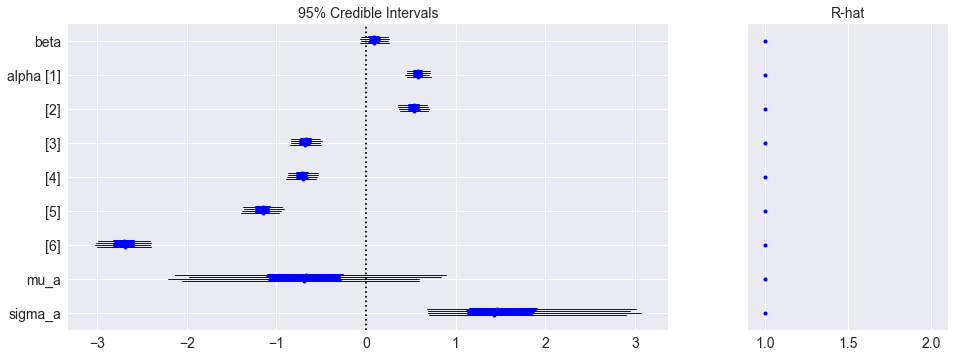

In [26]:
plt.figure(figsize=(15, 5))
forestplot(hierarchical_trace[1000:], varnames = ['beta', 'alpha', 'mu_a', 'sigma_a'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x11e227990>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x11cb040d0>]], dtype=object)

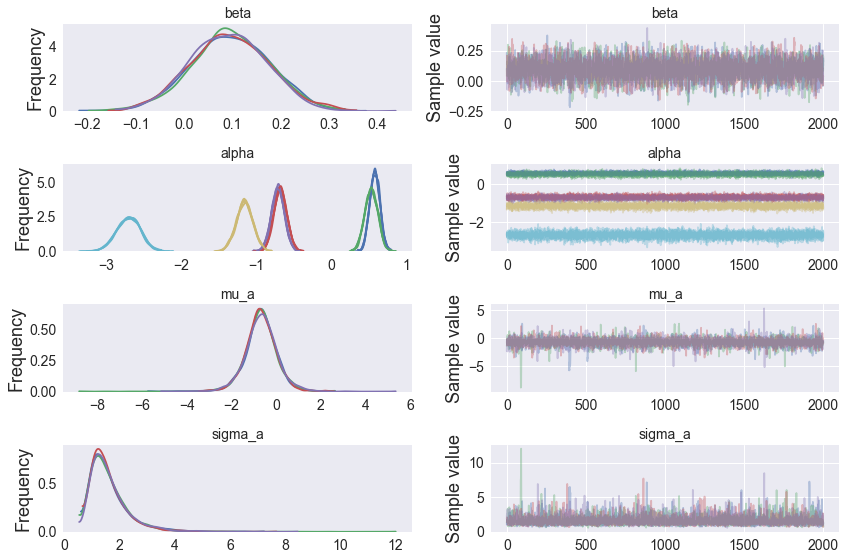

In [27]:
plt.figure(figsize=(15, 5))
pm.traceplot(hierarchical_trace[1000:], varnames = ['beta', 'alpha', 'mu_a', 'sigma_a'])

In [28]:
phat_hierarchical = pd.Series(hierarchical_trace[n_warm:]['p'].mean(axis = 0))
pstd_hierarchical = np.sqrt(phat_hierarchical*(1 - phat_hierarchical)/dfsort.applications)

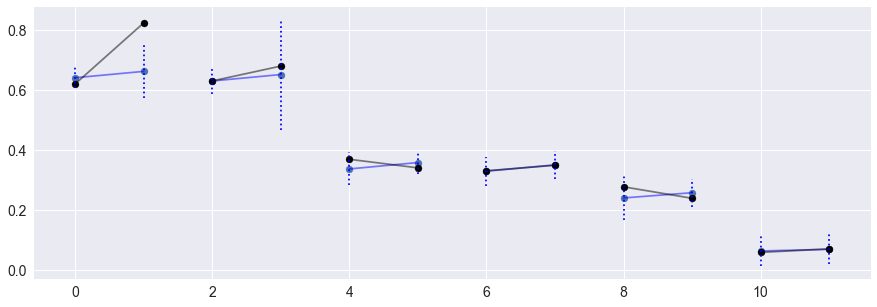

In [29]:
plt.figure(figsize=(15, 5))
plt.scatter(range(len(phat)), phat_hierarchical)
plt.scatter(range(len(phat)), pobs, c='k')
for i, m, se in zip(range(len(phat)), phat_hierarchical, pstd):
    plt.plot([i,i], [m-2*se, m+2*se], 'b:')
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [phat_hierarchical[i], phat_hierarchical[i+1]], 'b', alpha = .5)
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [pobs[i], pobs[i+1]], 'k', alpha = .5)

## Full hierarchical: *Varying slope and intercept*

In [30]:
with Model() as full_hierarchical:
    # Priors in 
    mu_a = Normal('mu_a', mu=0., sd=1e2)
    sigma_a = HalfCauchy('sigma_a', 5)
    
    mu_b = Normal('mu_b', mu=0., sd=1e2)
    sigma_b = HalfCauchy('sigma_b', 5)
    
    # Priors in regression coefficients
    beta = Normal('beta', mu_b, sd=sigma_b, shape = n_depts)
    alpha = Normal('alpha', mu_a, sd = sigma_a, shape=n_depts)
    # Linear model
    theta = alpha[dept] + beta[dept] * gender
    
    # To get posterior samples set as a deterministic transformation
    p = pm.Deterministic('p', pm.invlogit(theta))
    
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [33]:
n_samples = 5000
n_warm = 2000

with full_hierarchical:
    full_hierarchical_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)

Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...
Average Loss = 80.625:  71%|███████▏  | 14256/20000 [00:03<00:01, 4466.68it/s]
Convergence archived at 14300
Interrupted at 14,300 [71%]: Average Loss = 215.26
100%|█████████▉| 6990/7000 [00:43<00:00, 166.61it/s]/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: Chain 0 contains 9 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 7000/7000 [00:43<00:00, 162.16it/s]
/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: Chain 1 contains 31 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: 

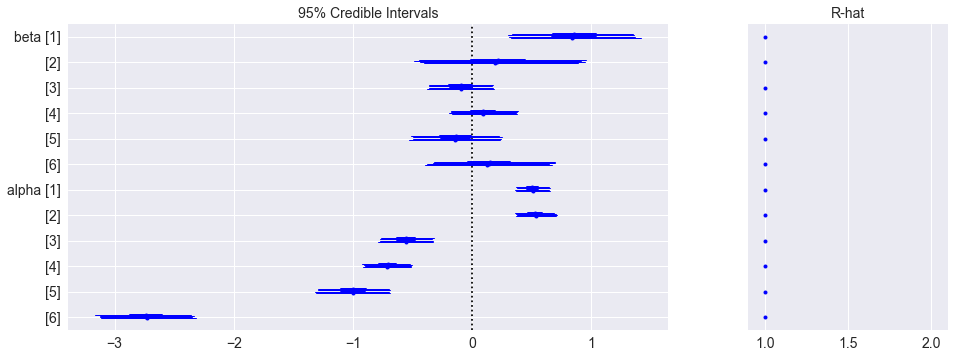

In [34]:
plt.figure(figsize=(15, 5))
forestplot(full_hierarchical_trace[n_warm:], varnames = ['beta', 'alpha'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x122c8e710>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x1223b1610>]], dtype=object)

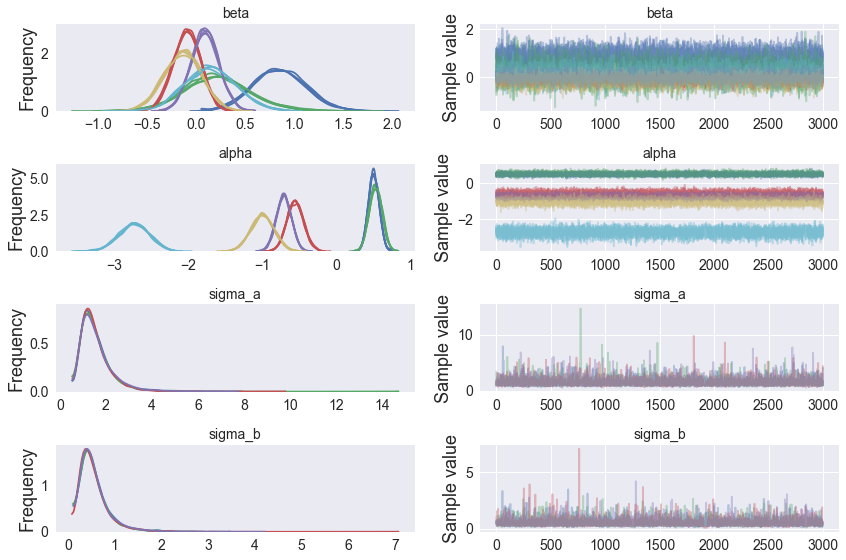

In [35]:
plt.figure(figsize=(15, 5))
traceplot(full_hierarchical_trace[n_warm:], varnames = ['beta', 'alpha', 'sigma_a', 'sigma_b'])

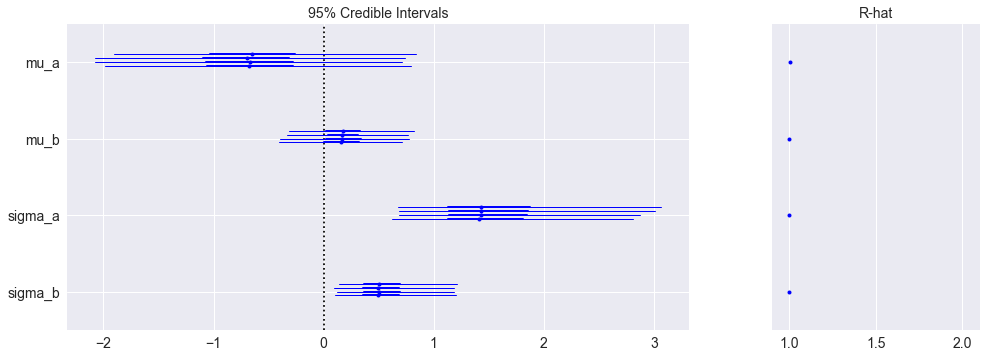

In [36]:
plt.figure(figsize=(15, 5))
forestplot(full_hierarchical_trace[n_warm:], varnames = ['mu_a', 'mu_b', 'sigma_a', 'sigma_b'])

In [37]:
phat_fhierarchical = pd.Series(full_hierarchical_trace[n_warm:]['p'].mean(axis = 0))
pstd_fhierarchical = np.sqrt(phat_fhierarchical*(1 - phat_fhierarchical)/dfsort.applications)

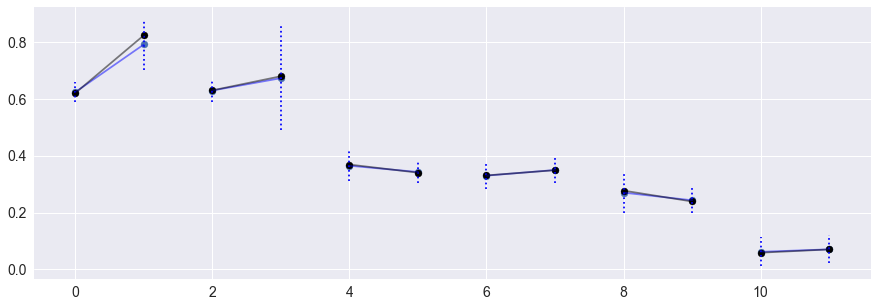

In [38]:
plt.figure(figsize=(15, 5))
plt.scatter(range(len(phat)), phat_fhierarchical)
plt.scatter(range(len(phat)), pobs, c='k')
for i, m, se in zip(range(len(phat)), phat_fhierarchical, pstd):
    plt.plot([i,i], [m-2*se, m+2*se], 'b:')
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [phat_fhierarchical[i], phat_fhierarchical[i+1]], 'b', alpha = .5)
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [pobs[i], pobs[i+1]], 'k', alpha = .5)

## Full hierarchical: *varying slope and intercept + centering* 

In [46]:
with Model() as fullc_hierarchical:
    # Priors in 
    mu_a = Normal('mu_a', mu=0., sd=1e2)
    sigma_a = HalfCauchy('sigma_a', 5)
    
    mu_b = Normal('mu_b', mu=0., sd=1e2)
    sigma_b = HalfCauchy('sigma_b', 5)
    
    # Priors in regression coefficients
    beta_off = Normal('beta_off', 0, sd=1, shape = n_depts)
    alpha_off = Normal('alpha_off', 0, sd = 1, shape=n_depts)

    beta = pm.Deterministic('beta', beta_off * sigma_b + mu_b)
    alpha = pm.Deterministic('alpha', alpha_off * sigma_a + mu_a)
    
    # Linear model
    theta = alpha[dept] + beta[dept] * gender

    # To get posterior samples set as a deterministic transformation
    p = pm.Deterministic('p', pm.invlogit(theta))
    
    y = Binomial('y', n = df.applications, p = p, observed = df.admit)

In [84]:
with fullc_hierarchical:
    approx = pm.fit(100000, callbacks=[pm.callbacks.CheckParametersConvergence(tolerance=1e-4)])

Average Loss = 84.802: 100%|██████████| 100000/100000 [00:20<00:00, 4811.62it/s]
Finished [100%]: Average Loss = 84.808


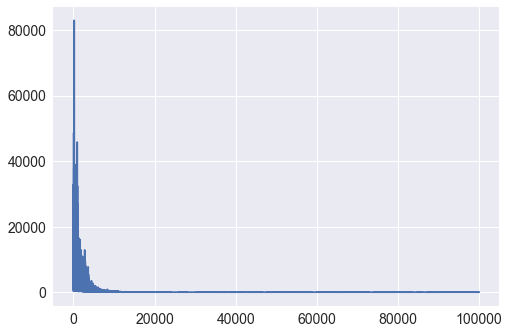

In [85]:
plt.plot(approx.hist)

In [94]:
n_samples = 6000
n_warm = 3000

with fullc_hierarchical:
    step = pm.NUTS(scaling=approx.cov.eval(), is_cov=True)
#    fullc_hierarchical_trace = sample(n_samples, n_init=n_opt, tune=n_warm, njobs = 4)
    fullc_hierarchical_trace = sample(n_samples, step, start=approx.sample()[0], progressbar=True, njobs = 4)

 97%|█████████▋| 6319/6500 [08:29<00:14, 12.63it/s]/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: Chain 1 contains 147 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
 99%|█████████▉| 6422/6500 [08:37<00:07, 10.80it/s]/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: Chain 3 contains 171 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|█████████▉| 6485/6500 [08:42<00:01, 13.28it/s]/Users/alfredogarbuno/anaconda2/envs/py2/lib/python2.7/site-packages/pymc3/step_methods/hmc/nuts.py:473: UserWarning: Chain 2 contains 139 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 6500/6500 [

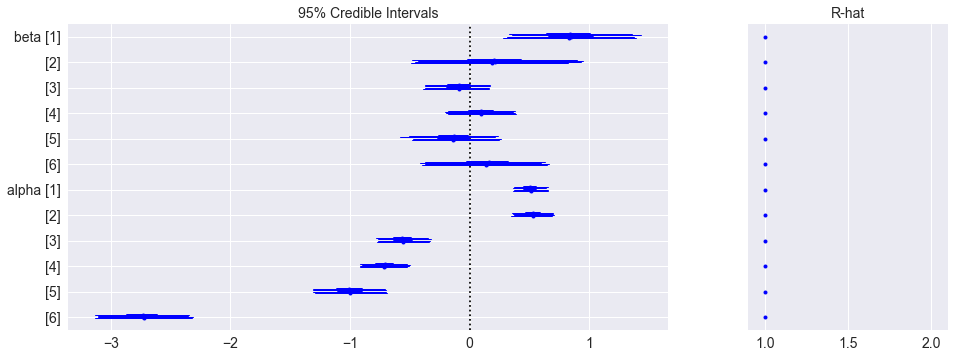

In [95]:
plt.figure(figsize=(15, 5))
forestplot(fullc_hierarchical_trace[n_warm:], varnames = ['beta', 'alpha'])

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12c200b50>,
        <matplotlib.axes._subplots.AxesSubplot object at 0x12b4ab810>]], dtype=object)

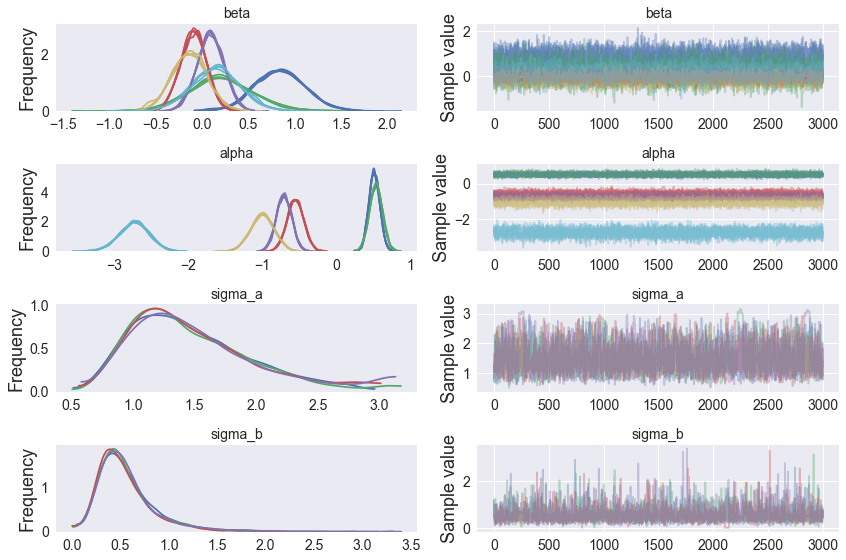

In [96]:
plt.figure(figsize=(15, 5))
traceplot(fullc_hierarchical_trace[n_warm:], varnames = ['beta', 'alpha', 'sigma_a', 'sigma_b'])

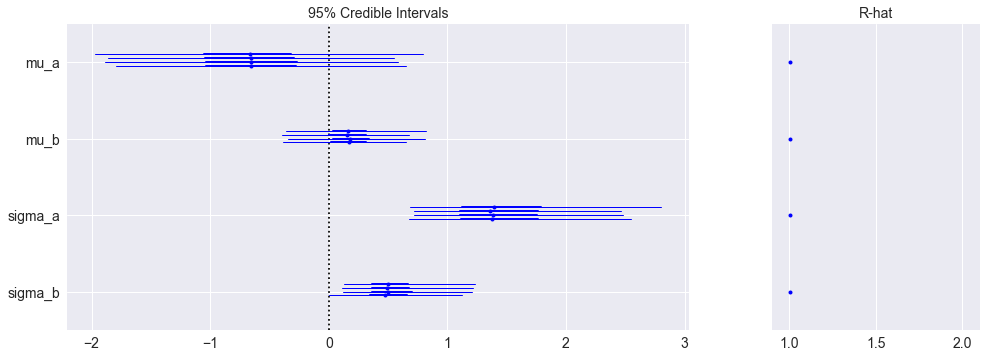

In [97]:
plt.figure(figsize=(15, 5))
forestplot(fullc_hierarchical_trace[n_warm:], varnames = ['mu_a', 'mu_b', 'sigma_a', 'sigma_b'])

In [51]:
phat_fchierarchical = pd.Series(full_hierarchical_trace[n_warm:]['p'].mean(axis = 0))
pstd_fchierarchical = np.sqrt(phat_fchierarchical*(1 - phat_fchierarchical)/dfsort.applications)

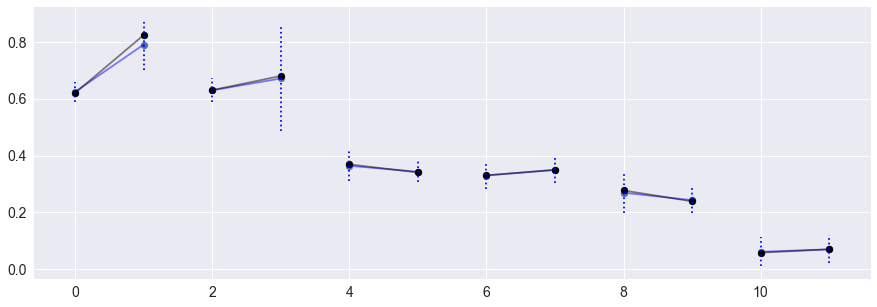

In [98]:
plt.figure(figsize=(15, 5))
plt.scatter(range(len(phat)), phat_fchierarchical)
plt.scatter(range(len(phat)), pobs, c='k')
for i, m, se in zip(range(len(phat)), phat_fchierarchical, pstd):
    plt.plot([i,i], [m-2*se, m+2*se], 'b:')
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [phat_fchierarchical[i], phat_fchierarchical[i+1]], 'b', alpha = .5)
for i in range(0,len(phat)-1,2):
    plt.plot([i,i+1], [pobs[i], pobs[i+1]], 'k', alpha = .5)

In [92]:
traces = [pooled_trace, unpooled_trace, hierarchical_trace, full_hierarchical_trace, fullc_hierarchical_trace]
models = [pooled_model, unpooled_model, hierarchical, full_hierarchical, fullc_hierarchical]
models_list = ['pooled', 'unpooled', 'var_interc', 'var_intslop', 'var_intslopc']

for t, m, n in zip(traces, models, models_list):
    print '%s  \t : %s' %(n, pm.stats.dic(t,m))

pooled  	 : 869.454660079
unpooled  	 : 148.696750194
var_interc  	 : 142.580367741
var_intslop  	 : 157.980582519
var_intslopc  	 : 158.835785309


In [93]:
pm.stats.compare(traces, models)

,WAIC,pWAIC,dWAIC,weight,SE,dSE,warning
4,89.7188,6.23183,0,0.582311,4.09348,0,0
3,90.3838,6.51953,0.664962,0.4176,4.19137,0.381688,0
2,108.024,9.08792,18.3055,6.16828e-05,15.564,13.6209,0
1,109.673,10.0979,19.9543,2.70483e-05,15.8673,13.824,0
0,988.715,113.251,898.996,3.55317e-196,310.679,311.081,0
